In [154]:
import stumpy
import pickle
import numpy as np
import sklearn.metrics as metrics

from pipelinetools import *
from multiprocessing import Pool
from sklearn.ensemble import RandomForestClassifier

np.set_printoptions(suppress=True)

In [2]:
# LOAD AND TRAIN THE MODEL

In [4]:
traces_train = load_traces('transformer_train')
traces_test = load_traces('transformer_test')
traces_kfp = load_traces('transformer_kfp')

In [5]:
train_pos = process_traces(traces_train, "p")
train_neg = process_traces(traces_train, "n")

100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.68it/s]


In [9]:
def make_merged_trace(traces_pos, traces_neg, traces):
    X_pos = []
    X_neg = []
    X = []
    y = []

    for i in tqdm(range(50000)):
        true_id = random.randint(0,49)
        true_idx = random.randint(0,len(traces_pos[true_id])-1)
        
        random_idx1 = random.randint(0,len(traces_pos[-1])-1)
        random_idx2 = random.randint(0,len(traces_pos[-1])-1)
        
        combo_pos = np.concatenate((
            traces_pos[-1][random_idx1],
            traces_pos[true_id][true_idx],
            traces_pos[-1][random_idx2],
        ))
        
        combo_neg = np.concatenate((
            traces_neg[-1][random_idx1],
            traces_neg[true_id][true_idx],
            traces_neg[-1][random_idx2],
        ))
        
        combo = np.concatenate((
            traces[-1][random_idx1],
            traces[true_id][true_idx],
            traces[-1][random_idx2],
        ))

        X_pos.append(combo_pos)
        X_neg.append(combo_neg)
        X.append(combo)
        y.append(true_id)

    return X_pos, X_neg, X, y

In [10]:
X_pos, X_neg, X, y = make_merged_trace(train_pos, train_neg, traces_train)

100%|███████████████████████████████████| 50000/50000 [00:05<00:00, 9751.43it/s]


In [11]:
test_pos = process_traces(traces_test, "p")
test_neg = process_traces(traces_test, "n")

del test_neg[-1]
del test_pos[-1]
del traces_test[-1]

100%|███████████████████████████████████████████| 51/51 [00:02<00:00, 20.18it/s]


(11532,)


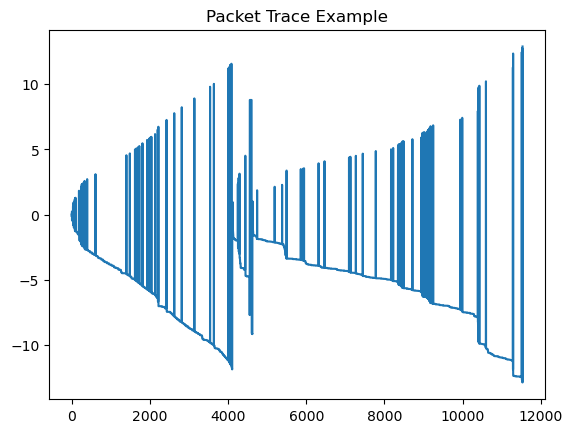

In [19]:
sample = X[100]
print(sample.shape)

plt.title("Packet Trace Example")
plt.plot(sample)

(11532,)
(11532,)


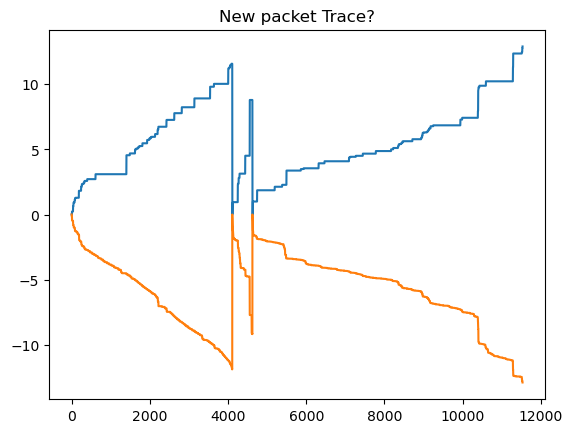

In [20]:
sample_pos = X_pos[100]
sample_neg = X_neg[100]

print(sample_pos.shape)
print(sample_neg.shape)

plt.title("New packet Trace?")
plt.plot(sample_pos)
plt.plot(sample_neg)

In [47]:
print("True Class: " + str(y[100]))
print(len(traces_test[0]))

True Class: 44
20


In [140]:
num_distances = len(traces_test[class_id])
heatmap = np.zeros((len(traces_test.keys()), len(sample)))
distances = np.zeros( (len(traces_test.keys()), num_distances) )
dropped_samples = []

print(heatmap.shape)
print(distances.shape)

for class_id in traces_test.keys():
    
    for i in range(num_distances):
        trace_pos = test_pos[class_id][i]
        
        try:
            stumpy_dist = stumpy.mass(trace_pos, sample_pos)
        except ValueError:
            print("Trace from " + str(class_id) + " too long")
            drop_samples.append(class_id)
            break
            
        min_idx = np.argmin(stumpy_dist)

        for j in range(len(trace_pos)):
            heatmap[class_id][min_idx + j] += 1
        distance_pos = stumpy_dist[min_idx]

        trace_neg = test_neg[class_id][i]

        stumpy_dist = stumpy.mass(trace_neg, sample_neg)
        min_idx = np.argmin(stumpy_dist)

        for j in range(len(trace_neg)):
            heatmap[class_id][min_idx + j] += 1
        distance_neg = stumpy_dist[min_idx]
        
        distances[class_id][i] = (distance_pos + distance_neg) / 2

(50, 11532)
(50, 20)
Trace from 9 too long
Trace from 19 too long
Trace from 22 too long
Trace from 23 too long
Trace from 25 too long
Trace from 31 too long
Trace from 42 too long


In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import pyplot

<AxesSubplot: >

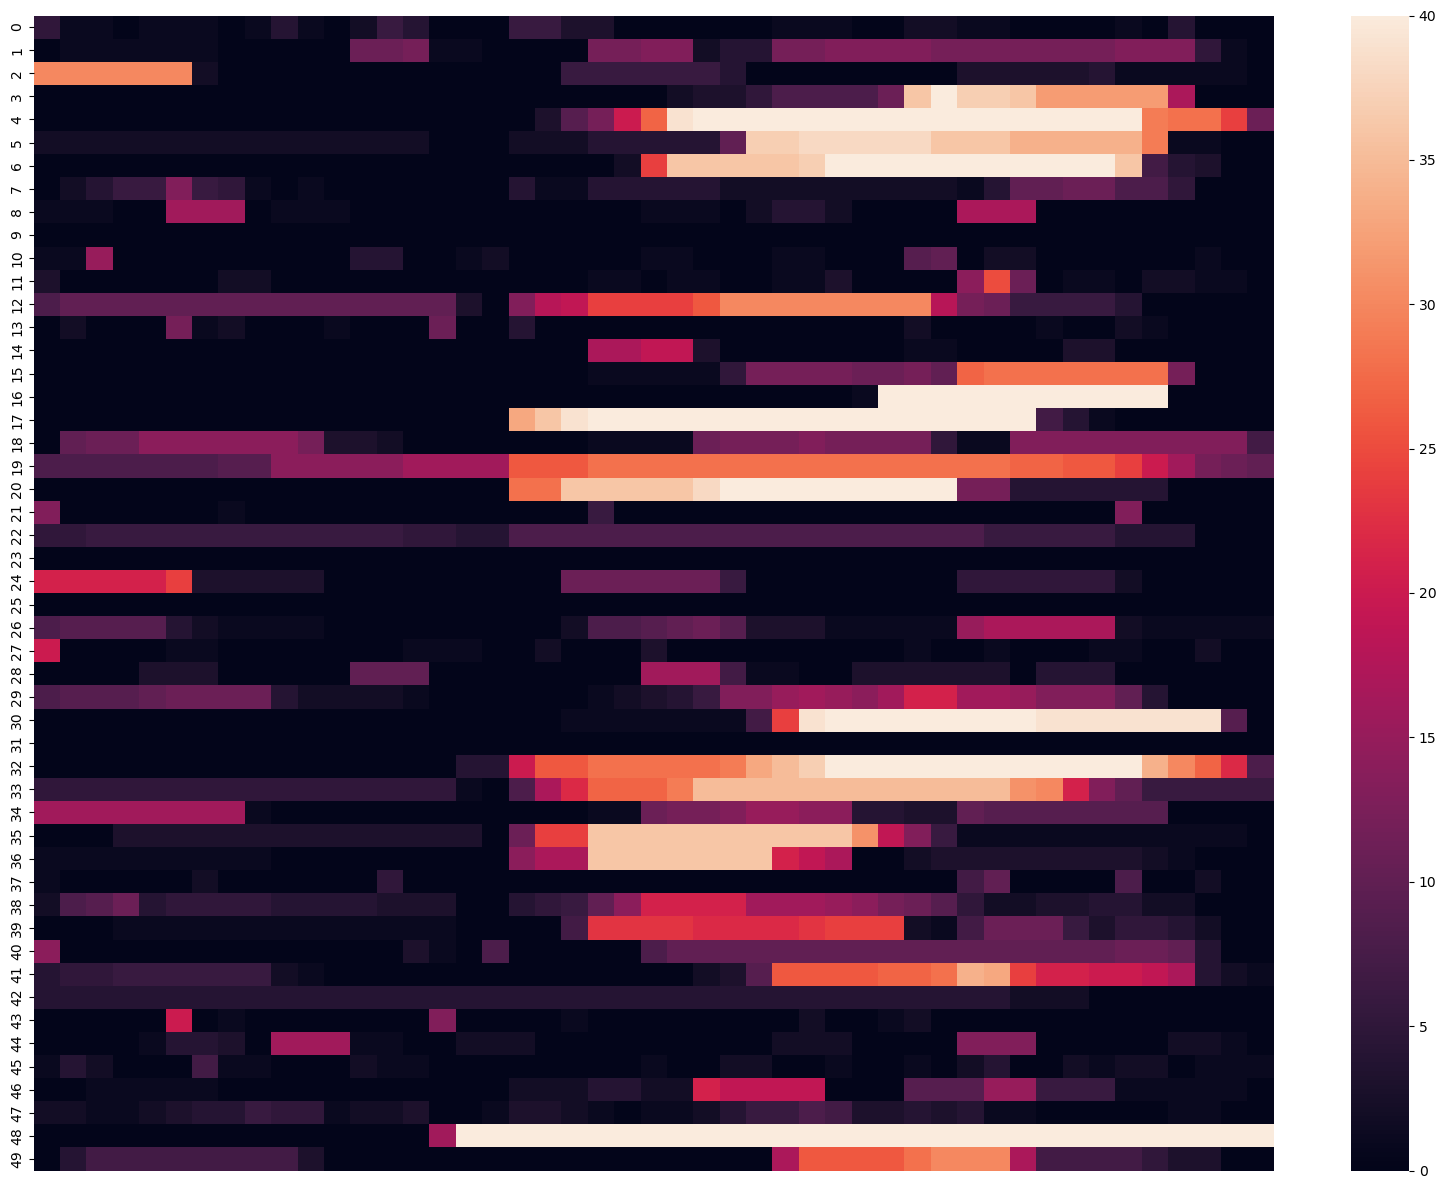

In [142]:
filter_size = 250
small_heatmap = np.zeros((50, round(heatmap.shape[1] / filter_size) + 1))
for i in range(50):
    for j in range(0, len(heatmap[i])-1, filter_size):
        small_heatmap[i][round(j/filter_size)] = np.max(heatmap[i][j:j+filter_size])
        
fig, axis = pyplot.subplots(figsize=(20,15))

axis.set(xlabel="Position of Best Match on Sample", ylabel="Class ID of Samples")
sns.heatmap(small_heatmap, ax=axis, xticklabels=False)

In [225]:
mean_dist = np.asarray([np.mean(distances[i]) for i in range(len(distances))])
norm_dist = (mean_dist-np.min(mean_dist))/(np.max(mean_dist)-np.min(mean_dist)) 

new_heatmap = np.zeros(heatmap.shape)

for i in range(len(new_heatmap)):
    for j in range(len(new_heatmap[i])):
        new_heatmap[i][j] = heatmap[i][j] * (1-norm_dist[i])

In [226]:
print(norm_dist[44])
print(1-norm_dist[44])

0.06149316355540672
0.9385068364445933


In [227]:
print(norm_dist[35])
print(1-norm_dist[35])

0.22316333174993014
0.7768366682500698


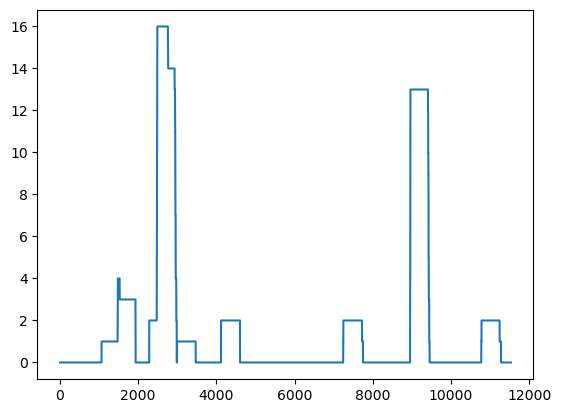

In [231]:
plt.plot(heatmap[44])

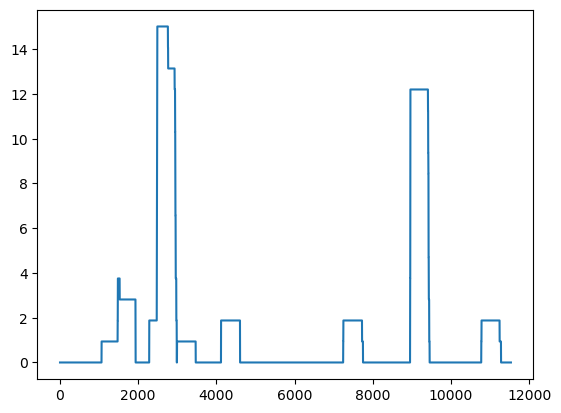

In [232]:
plt.plot(new_heatmap[44])

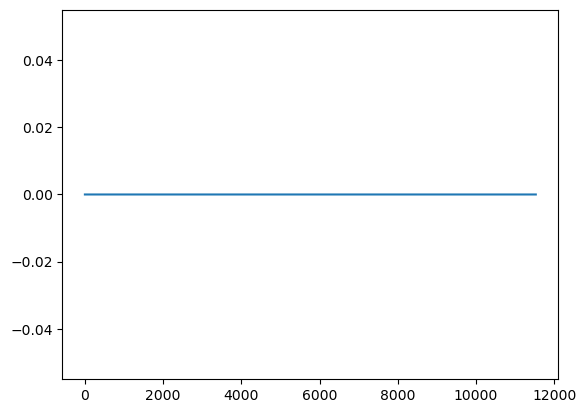

In [272]:
plt.plot(heatmap[48])

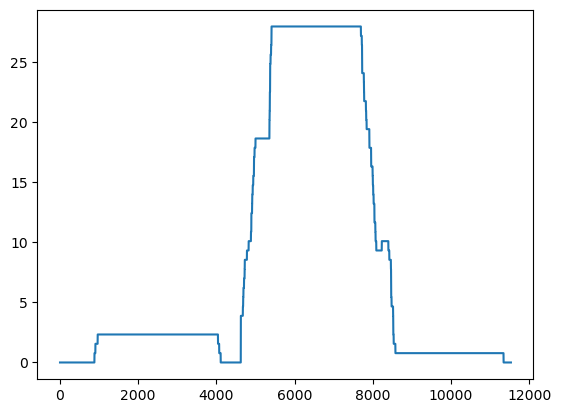

In [229]:
plt.plot(new_heatmap[35])

<AxesSubplot: >

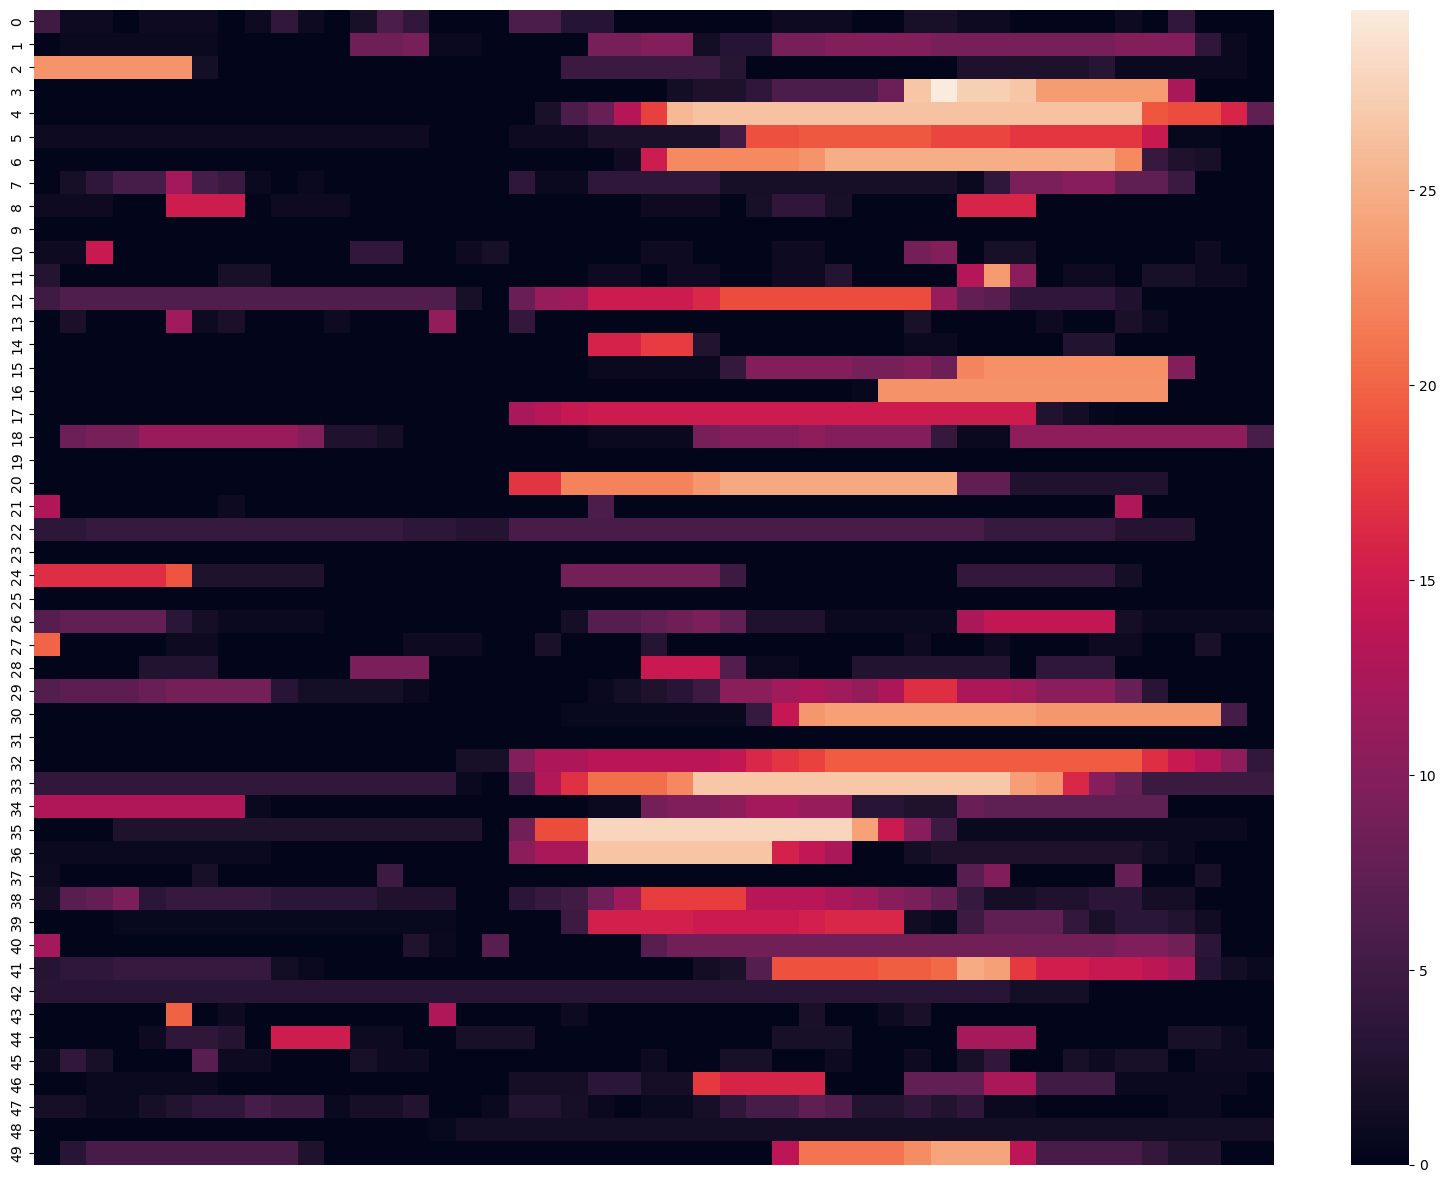

In [230]:
filter_size = 250
small_heatmap = np.zeros((50, round(new_heatmap.shape[1] / filter_size) + 1))
for i in range(50):
    for j in range(0, len(new_heatmap[i])-1, filter_size):
        small_heatmap[i][round(j/filter_size)] = np.max(new_heatmap[i][j:j+filter_size])
        
fig, axis = pyplot.subplots(figsize=(20,15))

axis.set(xlabel="Position of Best Match on Sample", ylabel="Class ID of Samples")
sns.heatmap(small_heatmap, ax=axis, xticklabels=False)

In [242]:
num_distances = len(traces_test[class_id])
heatmap = np.zeros((len(traces_test.keys()), len(sample)))
distances = np.zeros( (len(traces_test.keys()), num_distances) )
matched_traces_pos = np.zeros((num_distances, len(sample)))
matched_traces_neg = np.zeros((num_distances, len(sample)))

dropped_samples = []

print(heatmap.shape)
print(distances.shape)

class_id = 44

for i in range(num_distances):
    trace_pos = test_pos[class_id][i]

    stumpy_dist = stumpy.mass(trace_pos, sample_pos)
    min_idx = np.argmin(stumpy_dist)

    for j in range(len(trace_pos)):
        heatmap[class_id][min_idx + j] += 1
        matched_traces_pos[i][min_idx + j] = trace_pos[j]
    distance_pos = stumpy_dist[min_idx]

    trace_neg = test_neg[class_id][i]

    stumpy_dist = stumpy.mass(trace_neg, sample_neg)
    min_idx = np.argmin(stumpy_dist)

    for j in range(len(trace_neg)):
        heatmap[class_id][min_idx + j] += 1
        matched_traces_neg[i][min_idx + j] = trace_neg[j]
    distance_neg = stumpy_dist[min_idx]

    distances[class_id][i] = (distance_pos + distance_neg) / 2

(50, 11532)
(50, 20)


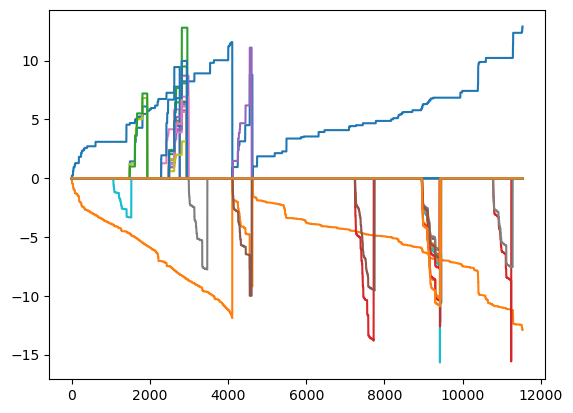

In [243]:
plt.plot(sample_pos)
plt.plot(sample_neg)


for i in range(len(matched_traces_pos)):
    plt.plot(matched_traces_pos[i])
    plt.plot(matched_traces_neg[i])

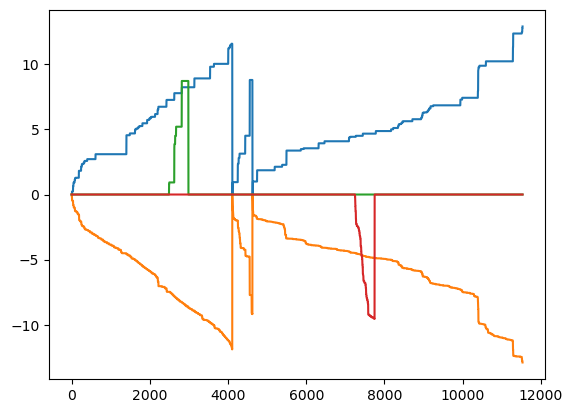

In [245]:
#ULTIMATE BEST-FITTING TRACE

plt.plot(sample_pos)
plt.plot(sample_neg)
plt.plot(matched_traces_pos[np.argmin(distances[class_id])])
plt.plot(matched_traces_neg[np.argmin(distances[class_id])])

In [236]:
num_distances = len(traces_test[class_id])
heatmap = np.zeros((len(traces_test.keys()), len(sample)))
distances = np.zeros( (len(traces_test.keys()), num_distances) )
matched_traces_pos = np.empty((num_distances, len(sample)))
matched_traces_neg = np.empty((num_distances, len(sample)))

dropped_samples = []

print(heatmap.shape)
print(distances.shape)

class_id = 35

for i in range(num_distances):
    trace_pos = test_pos[class_id][i]

    stumpy_dist = stumpy.mass(trace_pos, sample_pos)
    min_idx = np.argmin(stumpy_dist)

    for j in range(len(trace_pos)):
        heatmap[class_id][min_idx + j] += 1
        matched_traces_pos[i][min_idx + j] = trace_pos[j]
    distance_pos = stumpy_dist[min_idx]

    trace_neg = test_neg[class_id][i]

    stumpy_dist = stumpy.mass(trace_neg, sample_neg)
    min_idx = np.argmin(stumpy_dist)

    for j in range(len(trace_neg)):
        heatmap[class_id][min_idx + j] += 1
        matched_traces_neg[i][min_idx + j] = trace_neg[j]
    distance_neg = stumpy_dist[min_idx]

    distances[class_id][i] = (distance_pos + distance_neg) / 2

(50, 11532)
(50, 20)


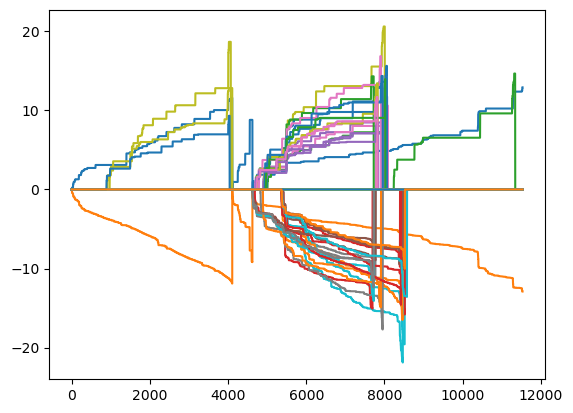

In [237]:
plt.plot(sample_pos)
plt.plot(sample_neg)

for i in range(len(matched_traces_pos)):
    plt.plot(matched_traces_pos[i])
    plt.plot(matched_traces_neg[i])